In [169]:
import pandas as pd
import numpy as np
import os
import matplotlib as plt

In [176]:
## Import do arquivo, conversão em array
cotas = pd.read_excel(f"{os.getcwd()}\\Cotas_2.xlsx",).fillna(0)
cotas.loc[:,~(cotas.columns == 1)]
display(cotas)
cotas = cotas.to_numpy()
cotas

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000,0.000000,0.711000,1.422000,2.844000,4.266000,5.688000,7.110000,8.532000,9.954000,11.376000,12.798000
1,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.651998,3.779004,5.301003,6.401998,7.133003
2,6.275,0.281195,0.753759,0.838000,0.838000,0.995999,1.957999,4.227998,6.270001,7.667001,8.452998,8.776005
3,12.550,0.542604,1.547002,1.869998,2.201001,2.791001,4.240005,6.302001,8.045999,9.169997,9.808002,10.133996
4,18.825,1.279997,2.502005,3.164001,3.941001,4.934001,6.389003,7.982000,9.274004,10.165996,10.663995,10.923003
5,25.100,2.200002,3.589005,4.630999,5.966998,7.006005,8.185005,9.281002,10.168995,10.849996,11.203003,11.374997
6,31.375,2.929996,5.019004,6.314996,7.826000,8.762998,9.610994,10.287997,10.814997,11.208001,11.409995,11.490000
7,37.650,4.299995,6.520001,7.998005,9.358996,10.061000,10.534997,10.899000,11.195006,11.361002,11.490000,11.490000
8,43.925,5.759994,8.137000,9.465002,10.570995,10.945994,11.158996,11.380994,11.490000,11.490000,11.490000,11.490000
9,50.200,7.132303,9.426005,10.514005,11.216998,11.348995,11.490000,11.490000,11.490000,11.490000,11.490000,11.490000


array([[0.00000000e+00, 0.00000000e+00, 7.11000000e-01, 1.42200000e+00,
        2.84400000e+00, 4.26600000e+00, 5.68800000e+00, 7.11000000e+00,
        8.53200000e+00, 9.95400000e+00, 1.13760000e+01, 1.27980000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.65199773e+00,
        3.77900355e+00, 5.30100342e+00, 6.40199820e+00, 7.13300349e+00],
       [6.27500000e+00, 2.81194770e-01, 7.53758937e-01, 8.38000170e-01,
        8.38000170e-01, 9.95999160e-01, 1.95799941e+00, 4.22799828e+00,
        6.27000108e+00, 7.66700124e+00, 8.45299767e+00, 8.77600455e+00],
       [1.25500000e+01, 5.42603760e-01, 1.54700211e+00, 1.86999750e+00,
        2.20100142e+00, 2.79100143e+00, 4.24000533e+00, 6.30200073e+00,
        8.04599889e+00, 9.16999665e+00, 9.80800188e+00, 1.01339962e+01],
       [1.88250000e+01, 1.27999749e+00, 2.50200495e+00, 3.16400130e+00,
        3.94100106e+00, 4.93400133e+00, 6.38900301e+00, 7.98

In [177]:

#Linhas em 0 (↓): eixo x
#Valores no encontro: eixo y
#Colunas em 0 (→): eixo z

#Para fins de facilitar a modelagem das splines, excluiremos a primeira linha
#d'água e a última baliza. Isto equivale a uma aproximação para um casco reto
#nestas regiões.
def eliminateZeros(tabelaCotas):
    tabelaCotas=tabelaCotas[:len(tabelaCotas)-1,:]
    tabelaCotas=np.delete(tabelaCotas,1,1)
    return tabelaCotas

def interpolSideways(tabelaCotas):
    
    #storeS é reponsável por ir armazenando os valores de newLine que são
    #valores novos de cada linha além dos já existentes
    storeS=[]
    
    #Formando a primera linha da nova matriz
    newLine=[tabelaCotas[0,0],tabelaCotas[0,1]]
    for j in range(2,len(tabelaCotas[0])):
        halfVal=tabelaCotas[0,j]-(tabelaCotas[0,j]-tabelaCotas[0,j-1])/2
        newLine.append(halfVal)
        newLine.append(tabelaCotas[0,j])
    
    storeS.append(newLine)    
       
    #Formando todas as novas linhas da nova matriz. newLine é resetado toda
    #vez que este loop é executado.
    for i in range(1,len(tabelaCotas)):
        
        #Calculo dos h's
        storeH=[]
        beginCounter=len(tabelaCotas[0])
        for j in range(2,len(tabelaCotas[0])):
            h=tabelaCotas[0,j]-tabelaCotas[0,j-1]
            if tabelaCotas[i,j]-tabelaCotas[i,j-1]!=0:
                storeH.append(h)
                beginCounter-=1
        
        #Calculo da matriz A e da matrz b
        A=np.zeros((len(storeH)-1,len(storeH)+1))
        b=np.zeros((len(storeH)-1))
        for m in range(len(storeH)-1):
            A[m,m]=storeH[m]
            A[m,m+1]=2*(storeH[m]+storeH[m+1])
            A[m,m+2]=storeH[m+1]
            
            b[m]=(tabelaCotas[i,m+beginCounter+1]-tabelaCotas[i,m+beginCounter])/storeH[m+1]-(tabelaCotas[i,m+beginCounter]-tabelaCotas[i,m+beginCounter-1])/storeH[m]
        
        A=A[:,1:len(A[0])-1] #Removendo primeira e última coluna para a operação
        b=6*b
        
        #Calculo da matriz x com os coeficientes g
        matrixX=np.linalg.solve(A,b)
        matrixX=np.append(matrixX, 0.0) #Adicionando o primeiro e último zero que foram retirados
        matrixX=np.insert(matrixX, 0, 0.0, axis=0)
        
        #Calculo das splines entre cada ponto e seu valor
        newLine=[tabelaCotas[i,0],tabelaCotas[i,1]]
        zeroCounter=2
        for k in range(2,len(tabelaCotas[0])):
            
            if tabelaCotas[i,k]-tabelaCotas[i,k-1]==0:
                newLine.append(0.0)
                newLine.append(tabelaCotas[i,k])
                zeroCounter+=1
            else:
                #Calculo dos coeficientes
                a=(matrixX[k-zeroCounter+1]-matrixX[k-zeroCounter])/(6*storeH[k-zeroCounter])
                b=matrixX[k-zeroCounter+1]/2
                c=(tabelaCotas[i,k]-tabelaCotas[i,k-1])/storeH[k-zeroCounter]+(2*storeH[k-zeroCounter]*matrixX[k-zeroCounter+1]+matrixX[k-zeroCounter]*storeH[k-zeroCounter])/6
                d=tabelaCotas[i,k]
                
                #Calculo do ponto entre dois conhecidos e append para ir construindo a nova linha
                halfVal=tabelaCotas[0,k]-(tabelaCotas[0,k]-tabelaCotas[0,k-1])/2
                s=a*(halfVal-tabelaCotas[0,k])**3+b*(halfVal-tabelaCotas[0,k])**2+c*(halfVal-tabelaCotas[0,k])+d

                newLine.append(s)
                newLine.append(tabelaCotas[i,k])
        
        storeS.append(newLine)
        
    #Transformando a lista final em matriz e atribuindo a tabela de cotas
    tabelaCotas=np.asarray(storeS)
    return tabelaCotas

def interpolDownwards(tabelaCotas):
    storeS=[]
    
    #Formando a primera coluna da nova matriz
    newColumn=[tabelaCotas[0,0],tabelaCotas[1,0]]
    for i in range(2,len(tabelaCotas)):
        halfVal=tabelaCotas[i,0]-(tabelaCotas[i,0]-tabelaCotas[i-1,0])/2
        newColumn.append(halfVal)
        newColumn.append(tabelaCotas[i,0])
    
    storeS.append(newColumn)    
       
    #Formando todas as novas colunas da nova matriz. newColumn é resetado toda
    #vez que este loop é executado.
    for j in range(1,len(tabelaCotas[0])):
        
        #Calculo dos h's
        storeH=[]
        beginCounter=len(tabelaCotas)
        for i in range(2,len(tabelaCotas)):
            h=tabelaCotas[i,0]-tabelaCotas[i-1,0]
            
            #Adicionamos apenas os h's diferentes de zero para nossa matriz
            #storeH para que calculemos apenas com no máximo 1 ponto igual a zero
            if tabelaCotas[i,j]-tabelaCotas[i-1,j]!=0:
                storeH.append(h)           
                beginCounter-=1
            
            #Para o caso de cada coluna precisamos fazer esta condição para não
            #obtermos erro no beginCounter
            elif tabelaCotas[i,j]-tabelaCotas[i-1,j]==0 and i>len(tabelaCotas)/2:
                beginCounter-=1
            
        #Calculo da matriz A e da matrz b
        A=np.zeros((len(storeH)-1,len(storeH)+1))
        b=np.zeros((len(storeH)-1))
        for m in range(len(storeH)-1):
            A[m,m]=storeH[m]
            A[m,m+1]=2*(storeH[m]+storeH[m+1])
            A[m,m+2]=storeH[m+1]
            
            b[m]=(tabelaCotas[m+beginCounter+1,j]-tabelaCotas[m+beginCounter,j])/storeH[m+1]-(tabelaCotas[m+beginCounter,j]-tabelaCotas[m+beginCounter-1,j])/storeH[m]
        A=A[:,1:len(A[0])-1] #Removendo primeira e última coluna para a operação
        b=6*b
        
        #Calculo da matriz x com os coeficientes g
        matrixX=np.linalg.solve(A,b)
        matrixX=np.append(matrixX, 0.0) #Adicionando o primeiro e último zero que foram retirados
        matrixX=np.insert(matrixX, 0, 0.0, axis=0)
     
        #Calculo das splines entre cada ponto e seu valor
        newColumn=[tabelaCotas[0,j],tabelaCotas[1,j]]
        zeroCounter=2
        for k in range(2,len(tabelaCotas)):
            
            if tabelaCotas[k,j]-tabelaCotas[k-1,j]==0:
                newColumn.append(0.0)
                newColumn.append(tabelaCotas[k,j])
                zeroCounter+=1
            else:
                #Calculo dos coeficientes
                a=(matrixX[k-zeroCounter+1]-matrixX[k-zeroCounter])/(6*storeH[k-zeroCounter])
                b=matrixX[k-zeroCounter+1]/2
                c=(tabelaCotas[k,j]-tabelaCotas[k-1,j])/storeH[k-zeroCounter]+(2*storeH[k-zeroCounter]*matrixX[k-zeroCounter+1]+matrixX[k-zeroCounter]*storeH[k-zeroCounter])/6
                d=tabelaCotas[k,j]
            
                #Calculo do ponto entre dois pontos conhecidos e append para ir 
                #construindo a nova coluna
                halfVal=tabelaCotas[k,0]-(tabelaCotas[k,0]-tabelaCotas[k-1,0])/2
                s=a*(halfVal-tabelaCotas[k,0])**3+b*(halfVal-tabelaCotas[k,0])**2+c*(halfVal-tabelaCotas[k,0])+d
                newColumn.append(s)
                newColumn.append(tabelaCotas[k,j])
        
        storeS.append(newColumn)
    
    #Transformando a lista em matriz e a tranpondo para obter ela em forma de colunas
    tabelaCotas=np.asarray(storeS).transpose()
    return tabelaCotas

def nInterpolBoth(tabelaCotas, n):
    for i in range(1,n+1):
        tabelaCotas=interpolDownwards(interpolSideways(tabelaCotas))

    return tabelaCotas

def nInterpolDownwards(tabelaCotas, n):
    for i in range(1,n+1):
        tabelaCotas=interpolDownwards(tabelaCotas)

    return tabelaCotas

def nInterpolSideways(tabelaCotas, n):
    for i in range(1,n+1):
        tabelaCotas=interpolSideways(tabelaCotas)

    return tabelaCotas
    
#-------------Definição do Calado e seu índice na tabela de Cotas-----------------------#

def chooseCalado(tabelaCotas, calado):
    
    caladoIndex=0
    for j in range(len(tabelaCotas[0])):
        if tabelaCotas[0,j]==calado:
            caladoIndex=j
        elif tabelaCotas[0,j]<calado and tabelaCotas[0,j+1]>calado:
            caladoIndex=j
    
    caladoTab=tabelaCotas[0,caladoIndex]
    print("\nCalado Considerado:",caladoTab)
    return caladoIndex, caladoTab

#------------Cálculo das propriedades hidroestaticas sem zeros--------------------------#
def hidroProps(tabelaCotas, caladoIndex, caladoTab):
    #i representa as linhas
    #j representa as colunas
    storeVectorA=[]
    storeScalarA=[]
    storeC=[]
    #--------------------Cálculo dos Painéis Laterais---------------------------- #   
    for i in range(1,len(tabelaCotas)-1):
        for j in range(2,caladoIndex+1):
            
            #Vetores painéis
            v1=np.array([0,tabelaCotas[i,j]-tabelaCotas[i,j-1],tabelaCotas[0,j]-tabelaCotas[0,j-1]]) #p2-p1
            v2=np.array([tabelaCotas[i+1,0]-tabelaCotas[i,0],tabelaCotas[i+1,j-1]-tabelaCotas[i+1,j],0]) #p4-p1
            v3=np.array([0,tabelaCotas[i+1,j-1]-tabelaCotas[i+1,j],tabelaCotas[0,j-1]-tabelaCotas[0,j]]) #p4-p3
            v4=np.array([tabelaCotas[i,0]-tabelaCotas[i+1,0],tabelaCotas[i,j]-tabelaCotas[i+1,j],0]) #p2-p3
            
            #Calculo vetor A e C do painel sendo analisado
            currentA=0.5*(np.cross(v1,v2)+np.cross(v3,v4))
            currentC=np.array([(2*tabelaCotas[i,0]+2*tabelaCotas[i+1,0])/4,(tabelaCotas[i,j]+tabelaCotas[i,j-1]+tabelaCotas[i+1,j-1]+tabelaCotas[i+1,j])/4,(2*tabelaCotas[0,j]+2*tabelaCotas[0,j-1])/4])
            
            #Guardando A em forma vetor e escalar e C vetor em listas
            storeVectorA.append(currentA.copy())
            storeScalarA.append(np.linalg.norm(currentA))
            storeC.append(currentC)
            
            #Para o outro lado
            v1=np.array([tabelaCotas[i+1,0]-tabelaCotas[i,0],(-tabelaCotas[i+1,j-1])-(-tabelaCotas[i,j-1]),0]) #p2-p1
            v2=np.array([0,(-tabelaCotas[i,j])-(-tabelaCotas[i,j-1]),tabelaCotas[0,j]-tabelaCotas[0,j-1]]) #p4-p1
            v3=np.array([tabelaCotas[i,0]-tabelaCotas[i+1,0],(-tabelaCotas[i,j])-(-tabelaCotas[i+1,j]),0]) #p4-p3
            v4=np.array([0,(-tabelaCotas[i+1,j-1])-(-tabelaCotas[i+1,j]),tabelaCotas[0,j-1]-tabelaCotas[0,j]]) #p2-p3
            
            currentA=0.5*(np.cross(v1,v2)+np.cross(v3,v4))
            currentC=np.array([(2*tabelaCotas[i,0]+2*tabelaCotas[i+1,0])/4,(-tabelaCotas[i,j]-tabelaCotas[i,j-1]-tabelaCotas[i+1,j-1]-tabelaCotas[i+1,j])/4,(2*tabelaCotas[0,j]+2*tabelaCotas[0,j-1])/4])
            
            storeVectorA.append(currentA.copy())
            storeScalarA.append(np.linalg.norm(currentA))
            storeC.append(currentC.copy())
            
    #----------------------Cálculo dos painéis da Popa----------------------------#
    storeVectorPopA=[]
    storeScalarPopA=[]
    storePopC=[]
    
    for j in range(1,caladoIndex):
        v1=np.array([0,0,tabelaCotas[0,j+1]-tabelaCotas[0,j]])#p2-p1
        v2=np.array([0,tabelaCotas[1,j],0])#p4-p1
        v3=np.array([0,tabelaCotas[1,j]-tabelaCotas[1,j+1],tabelaCotas[0,j]-tabelaCotas[0,j+1]])#p4-p3
        v4=np.array([0,0-tabelaCotas[1,j+1],0])#p2-p3
        
        currentA=0.5*(np.cross(v1,v2)+np.cross(v3,v4))
        currentC=np.array([0,(tabelaCotas[1,j]+tabelaCotas[1,j+1])/4,(2*tabelaCotas[0,j]+2*tabelaCotas[0,j+1])/4])
        
        storeVectorPopA.append(currentA.copy())
        storeScalarPopA.append(np.linalg.norm(currentA))
        storePopC.append(currentC.copy())
        
        #Do outro lado
        v1=np.array([0,-tabelaCotas[1,j],0])#p2-p1
        v2=np.array([0,0,tabelaCotas[0,j+1]-tabelaCotas[0,j]])#p4-p1
        v3=np.array([0,tabelaCotas[1,j+1],0])#p4-p3
        v4=np.array([0,-tabelaCotas[1,j]-(-tabelaCotas[1,j+1]),tabelaCotas[0,j]-tabelaCotas[0,j+1]])#p2-p3
        
        currentA=0.5*(np.cross(v1,v2)+np.cross(v3,v4))
        currentC=np.array([0,(-tabelaCotas[1,j]-tabelaCotas[1,j+1])/4,(2*tabelaCotas[0,j]+2*tabelaCotas[0,j+1])/4])
        
        storeVectorPopA.append(currentA.copy())
        storeScalarPopA.append(np.linalg.norm(currentA))
        storePopC.append(currentC.copy())
        
    #-----------------------Cálculo dos painéis do Topo-------------------------------#
    
    storeVectorTopA=[]
    storeScalarTopA=[]
    storeTopC=[]
    storeBal=[]
    
    #Formando a matriz do plano da linha d'água matrixYWL
    matrixYWL=tabelaCotas[1:,:caladoIndex+1] #É extraído a primeira coluna com os valores de x até a coluna com a spline da linha d'água do calado
    matrixYWL=np.delete(matrixYWL,np.s_[1:len(matrixYWL[0])-1],axis=1) #Deletamos todas as colunas entre essas duas colunas
    
    #Loop para obter valores igualmente espaçados do y=0 até y=spline para cada baliza
    for i in range(len(matrixYWL)):
        currentBal=np.linspace(0,matrixYWL[i,-1],len(tabelaCotas[0])*5) #Aqui é definido a malha do plano de flutuação
        currentBal=np.insert(currentBal,0,matrixYWL[i,0],axis=0)
        storeBal.append(currentBal)
    
    #Transformando lista em matriz    
    matrixYWL=np.asarray(storeBal)
    
    #Cálculo do vetores e painéis
    for i in range(len(matrixYWL)-1):
        for j in range(2,len(matrixYWL[0])):
            v1=np.array([matrixYWL[i+1,0]-matrixYWL[i,0],matrixYWL[i+1,j-1]-matrixYWL[i,j-1],caladoTab])#p2-p1
            v2=np.array([0,matrixYWL[i,j]-matrixYWL[i,j-1],caladoTab])#p4-p1
            v3=np.array([matrixYWL[i,0]-matrixYWL[i+1,0],matrixYWL[i,j]-matrixYWL[i+1,j],caladoTab])#p4-p3
            v4=np.array([0,matrixYWL[i+1,j-1]-matrixYWL[i+1,j],caladoTab])#p2-p3
            
            currentA=0.5*(np.cross(v1,v2)+np.cross(v3,v4))
            currentC=np.array([(2*matrixYWL[i,0]+2*matrixYWL[i+1,0])/4,(matrixYWL[i,j]+matrixYWL[i,j-1]+matrixYWL[i+1,j-1]+matrixYWL[i+1,j])/4,caladoTab])
            
            storeVectorTopA.append(currentA.copy())
            storeScalarTopA.append(np.linalg.norm(currentA))
            storeTopC.append(currentC.copy())
    
            #Para o outro lado
            v1=np.array([matrixYWL[i+1,0]-matrixYWL[i,0],-matrixYWL[i+1,j]-(-matrixYWL[i,j]),caladoTab])#p2-p1
            v2=np.array([0,-matrixYWL[i,j-1]-(-matrixYWL[i,j]),caladoTab])#p4-p1
            v3=np.array([matrixYWL[i,0]-matrixYWL[i+1,0],-matrixYWL[i,j-1]-(-matrixYWL[i+1,j-1]),caladoTab])#p4-p3
            v4=np.array([0,-matrixYWL[i+1,j]-(-matrixYWL[i+1,j-1]),caladoTab])#p2-p3
            
            currentA=0.5*(np.cross(v1,v2)+np.cross(v3,v4))
            currentC=np.array([(2*matrixYWL[i,0]+2*matrixYWL[i+1,0])/4,(-matrixYWL[i,j]-matrixYWL[i,j-1]-matrixYWL[i+1,j-1]-matrixYWL[i+1,j])/4,caladoTab])
                     
            storeVectorTopA.append(currentA.copy())
            storeScalarTopA.append(np.linalg.norm(currentA))
            storeTopC.append(currentC.copy())
    
    #------------------------Cálculo painéis do Fundo-----------------------------#
    
    storeVectorBotA=[]
    storeScalarBotA=[]
    storeBotC=[]
    
    for i in range(2,len(tabelaCotas)):
        v1=np.array([tabelaCotas[i,0]-tabelaCotas[i-1,0],tabelaCotas[i,1]-tabelaCotas[i-1,1],0])
        v2=np.array([0,-tabelaCotas[i-1,1],0])
        v3=np.array([tabelaCotas[i-1,0]-tabelaCotas[i,0],0,0])#p4-p3
        v4=np.array([0,tabelaCotas[i,1],0])
        
        currentA=0.5*(np.cross(v1,v2)+np.cross(v3,v4))
        currentC=np.array([(2*tabelaCotas[i,0]+2*tabelaCotas[i-1,0])/4,(tabelaCotas[i,1]+tabelaCotas[i-1,1])/4,(2*tabelaCotas[0,1])/4])
        
        storeVectorBotA.append(currentA.copy())
        storeScalarBotA.append(np.linalg.norm(currentA))
        storeBotC.append(currentC.copy())
        
        v1=np.array([tabelaCotas[i,0]-tabelaCotas[i-1,0],0,0])#p2-p1
        v2=np.array([0,tabelaCotas[i-1,1],0])#p4-p1
        v3=np.array([tabelaCotas[i-1,0]-tabelaCotas[i,0],-tabelaCotas[i-1,1]-(-tabelaCotas[i,1]),0])#p4-p3
        v4=np.array([0,0-(-tabelaCotas[i,1]),0])#p2-p3
        
        currentA=0.5*(np.cross(v1,v2)+np.cross(v3,v4))
        currentC=np.array([(2*tabelaCotas[i,0]+2*tabelaCotas[i-1,0])/4,(-tabelaCotas[i,1]-tabelaCotas[i-1,1])/4,(2*tabelaCotas[0,1])/4])
        
        storeVectorBotA.append(currentA.copy())
        storeScalarBotA.append(np.linalg.norm(currentA))
        storeBotC.append(currentC.copy())
        
    #---------------------Área da superfície Molhada (Sw)---------------------------- #     
    wetS=0
    
    #Todos os painéis multiplicamos por dois para levarmos em conta seu simétrico também
    wetS+=np.sum(storeScalarA)
    wetS+=np.sum(storeScalarBotA)
    wetS+=np.sum(storeScalarPopA)
    
    print("\nSw:",wetS)
    #-------------------Área do plano da linha d'água (Awl)---------------------------#
    
    wetA=0
    storeVectorTopAarray=np.asarray(storeVectorTopA)
    
    wetA=storeVectorTopAarray[:,2].sum(axis=0)
    
    print("\nAw:",wetA) 
    
    
    #------------------------Cálculo de ∇---------------------------------------------#
    xTerm, yTerm, zTerm = 0, 0, 0
    
    for i in range(len(storeVectorA)):
        xTerm+=storeVectorA[i][0]*storeC[i][0]
        yTerm+=storeVectorA[i][1]*storeC[i][1]
        zTerm+=storeVectorA[i][2]*storeC[i][2]    
    
    for i in range(len(storeVectorPopA)):
        xTerm+=storeVectorPopA[i][0]*storePopC[i][0]
        yTerm+=storeVectorPopA[i][1]*storePopC[i][1]
        zTerm+=storeVectorPopA[i][2]*storePopC[i][2]
       
    for i in range(len(storeVectorBotA)):
        xTerm+=storeVectorBotA[i][0]*storeBotC[i][0]
        yTerm+=storeVectorBotA[i][1]*storeBotC[i][1]
        zTerm+=storeVectorBotA[i][2]*storeBotC[i][2]
    
    for i in range(len(storeVectorTopA)):
        xTerm+=storeVectorTopA[i][0]*storeTopC[i][0]
        yTerm+=storeVectorTopA[i][1]*storeTopC[i][1]
        zTerm+=storeVectorTopA[i][2]*storeTopC[i][2]
         
    nabla=(xTerm+yTerm+zTerm)/3
    print("\nNabla(∇):",nabla)
    desloc=nabla*1.025
    print("\nDeslocamento(Δ):",desloc)
    
    #------------------------Cálculo do plano de Flutuação---------------------------#
    
    LCFnumerador, LCFandTCFdenominador,TCFnumerador = 0, 0, 0
    
    for i in range(len(storeVectorTopA)):
        
        LCFnumerador+=(-storeVectorTopA[i][2])*storeTopC[i][0]
        TCFnumerador+=(-storeVectorTopA[i][2])*storeTopC[i][1]   
    
        LCFandTCFdenominador+=(-storeVectorTopA[i][2])
    
    LCF=LCFnumerador/LCFandTCFdenominador
    TCF=TCFnumerador/LCFandTCFdenominador
    
    print("\nLCF, TCF:",LCF, TCF)
    
    #-------------------------Cálculo dos momentos de Inércia-----------------------#
    
    inertiaL, inertiaT = 0, 0
    
    for i in range(len(storeVectorTopA)):
        #Lembrar delft usa a notação trocada
        inertiaT+=(storeVectorTopA[i][2]*(storeTopC[i][1]-TCF)**2)
        inertiaL+=(storeVectorTopA[i][2]*(storeTopC[i][0]-LCF)**2)
    
    print("\nIt, Il:",inertiaT,inertiaL)
    
    #--------------------------Cálculos do Centro de Carena-------------------------#
    
    LCB, TCB, KB = 0, 0, 0
    
    for i in range(len(storeVectorA)):
        LCB+=(storeVectorA[i][0]*storeC[i][0]*storeC[i][0]/2)
        TCB+=(storeVectorA[i][1]*storeC[i][1]*storeC[i][1]/2)
        KB+=(storeVectorA[i][2]*storeC[i][2]*storeC[i][2]/2)
    
    for i in range(len(storeVectorPopA)):
        LCB+=(storeVectorPopA[i][0]*storePopC[i][0]*storePopC[i][0]/2)
        TCB+=(storeVectorPopA[i][1]*storePopC[i][1]*storePopC[i][1]/2)
        KB+=(storeVectorPopA[i][2]*storePopC[i][2]*storePopC[i][2]/2)
    
    for i in range(len(storeVectorBotA)):
        LCB+=(storeVectorBotA[i][0]*storeBotC[i][0]*storeBotC[i][0]/2)
        TCB+=(storeVectorBotA[i][1]*storeBotC[i][1]*storeBotC[i][1]/2)
        KB+=(storeVectorBotA[i][2]*storeBotC[i][2]*storeBotC[i][2]/2)
        
    for i in range(len(storeVectorTopA)):
        LCB+=(storeVectorTopA[i][0]*storeTopC[i][0]*storeTopC[i][0]/2)
        TCB+=(storeVectorTopA[i][1]*storeTopC[i][1]*storeTopC[i][1]/2)
        KB+=(storeVectorTopA[i][2]*storeTopC[i][2]*storeTopC[i][2]/2)
       
    LCB=LCB/nabla
    TCB=TCB/nabla
    KB=KB/nabla
    
    print("\nLCB, TCB, KB:",LCB,TCB,KB)
    
    BML=inertiaL/nabla
    BMT=inertiaT/nabla
    
    print("\nBML, BMT:", BML,BMT)
    
    return (wetS , wetA, nabla, LCF, TCF, inertiaT, inertiaL, LCB, TCB, KB, BML, BMT, desloc)

#------------------------------------------------------------------------------------#    

#Aproximando a nossa tabela de Cotas
#tabelaCotas=eliminateZeros(tabelaCotas)
#Fazendo quatro interpolções para cada direação. Após este número de interpolações não há mudanças significativas nos valores hidroestáticos
tabelaCotas=nInterpolBoth(cotas, 4)

#Loop para obter propriedades por calado
resultsPerCalado=[]
inputs=np.arange(0.75,3.25,0.25)
for i in range(len(inputs)):
    resultsCalado=chooseCalado(tabelaCotas, inputs[i])
    caladoIndex, caladoTab = resultsCalado[0], resultsCalado[1]
    resultsPerCalado.append(hidroProps(tabelaCotas, caladoIndex, caladoTab))

data=[]
inputs=inputs.tolist()
parameters=["Área da superfície molhada (Sw) [m2]","Área do plano de linha d'água (Awl) [m2]","Volume Deslocado [m3]","LCF [m]","TCF [m]","Inércia transversal (IT) [m4]","Inércia longitudinal (IL) [m4]","LCB [m]","TCB [m]","KB [m]","BML [m]","BMT [m]","Deslocamento (Δ) [t]"]

#Loop para obter cada propriedades separadas em listas
for j in range(len(resultsPerCalado[0])):
    currentData=[]
    for i in range(len(resultsPerCalado)):
        currentData.append(resultsPerCalado[i][j])
    
    data.append(currentData)
    
#Loop para plotar todos os gráficos
for i in range(len(parameters)):
    plt.plot(inputs,data[i])
    plt.xlabel("Calado")
    plt.ylabel(str(parameters[i]))
    plt.title(str(parameters[i]) + "  X Calado [m]")
    plt.show()
  
#Loop para printar as listas com o valores de cada propriedade por calado      
print("\nCalados:", inputs)
for i in range(len(data)):
    print("\n"+str(parameters[i])+":",data[i])



Calado Considerado: 0.711

Sw: 858.3871150918358

Aw: 1178.8813049113783

Nabla(∇): 885.2480176721048

Deslocamento(Δ): 907.3792181139073

LCF, TCF: 59.39112063366718 -0.0

It, Il: 22889.018120283046 603677.5535720758

LCB, TCB, KB: 66.12260085000318 0.0 0.2981646758325116

BML, BMT: 681.9304212163483 25.856051257220802

Calado Considerado: 0.977625

Sw: 992.4763193062552

Aw: 1286.7529973844476

Nabla(∇): 1255.3048498786156

Deslocamento(Δ): 1286.687471125581

LCF, TCF: 60.03180873307379 -0.0

It, Il: 27444.09937426982 696653.5770184022

LCB, TCB, KB: 64.83029843222894 0.0 0.43220783926390993

BML, BMT: 554.9676455769023 21.862497684864028

Calado Considerado: 1.24425

Sw: 1118.8233284652856

Aw: 1386.7036040766893

Nabla(∇): 1645.3034279939877

Deslocamento(Δ): 1686.4360136938374

LCF, TCF: 60.518621657306696 -0.0

It, Il: 32705.643012474276 778751.5344255762

LCB, TCB, KB: 63.774478506241444 0.0 0.5709717342512418

BML, BMT: 473.3178823890604 19.878183231132116

Calado Considerado:

AttributeError: module 'matplotlib' has no attribute 'plot'

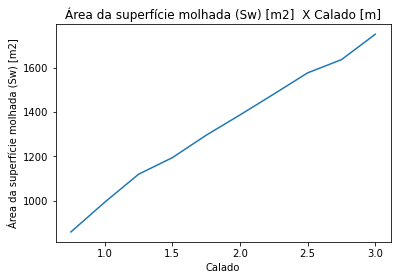

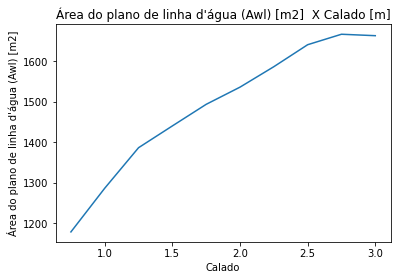

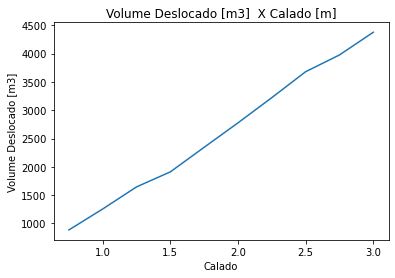

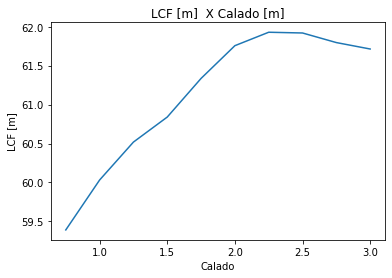

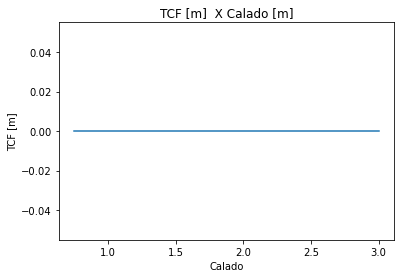

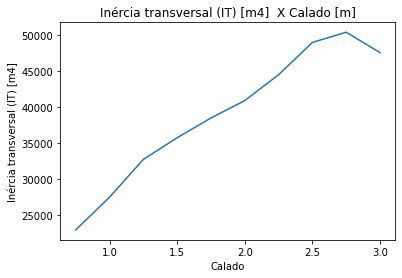

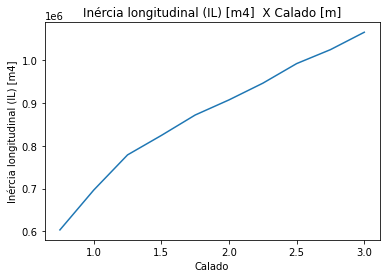

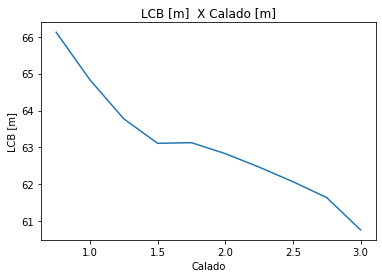

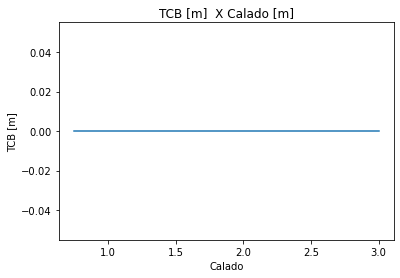

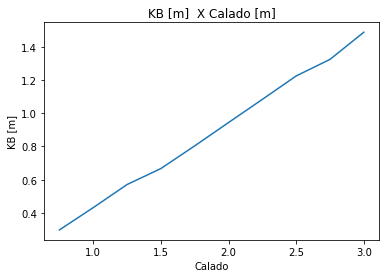

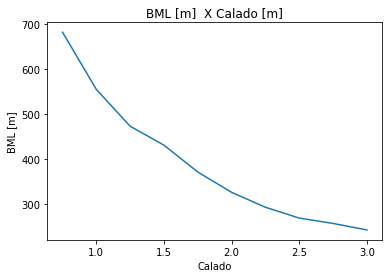

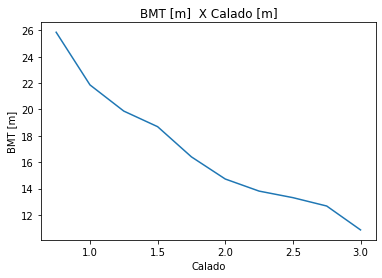

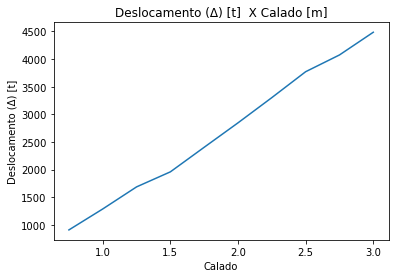


Calados: [0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]

Área da superfície molhada (Sw) [m2]: [858.3871150918358, 992.4763193062552, 1118.8233284652856, 1193.8501530432268, 1295.1341288058659, 1386.7354113928147, 1480.9799049623227, 1576.7607829809301, 1636.2992444463096, 1751.089059169331]

Área do plano de linha d'água (Awl) [m2]: [1178.8813049113783, 1286.7529973844476, 1386.7036040766893, 1440.475350732722, 1493.7624262213997, 1536.175570271426, 1586.6243009653467, 1640.8662047595662, 1666.7044551861773, 1663.1372147778034]

Volume Deslocado [m3]: [885.2480176721048, 1255.3048498786156, 1645.3034279939877, 1910.9918611227993, 2345.152017632445, 2776.706716045365, 3222.265366603709, 3679.789536568105, 3975.7643646825404, 4376.9453504687]

LCF [m]: [59.39112063366718, 60.03180873307379, 60.518621657306696, 60.83986237435772, 61.335849513063266, 61.75619903991336, 61.92862197888284, 61.9190707471489, 61.79604021764196, 61.71344583663977]

TCF [m]: [-0.0, -0.0, -0.0, -0.0, -

In [178]:
import matplotlib.pyplot as plt
for i in range(len(parameters)):
    plt.plot(inputs,data[i])
    plt.xlabel("Calado")
    plt.ylabel(str(parameters[i]))
    plt.title(str(parameters[i]) + "  X Calado [m]")
    plt.show()
  
#Loop para printar as listas com o valores de cada propriedade por calado      
print("\nCalados:", inputs)
for i in range(len(data)):
    print("\n"+str(parameters[i])+":",data[i])
